In [1]:
import os
import cv2
import numpy as np
import h5py
import matplotlib.pyplot as plt
from tensorflow.keras.layers import InputLayer, Dense, Dropout, Conv2D, MaxPooling2D, Flatten, AveragePooling2D,PReLU
from tensorflow.keras.callbacks import ReduceLROnPlateau
from sklearn.metrics import  confusion_matrix,precision_score,accuracy_score,recall_score,ConfusionMatrixDisplay
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Nadam
import tensorflow as tf
import pandas as pd

In [2]:
URL="./Videos"


In [3]:
metricas={"precision":[],"recall":[]}

## Funciones definidas

In [4]:
def obtenerDatos(archivo):
   data=h5py.File(archivo)
   return data["X"][:],data["Y"][:] 

In [5]:
def obtener_etiquetas(url):
    labels=[]
    for index,carpeta in enumerate(os.listdir(str(url))):
        labels.append(carpeta)
    return labels

In [6]:
def normalizar(X):
    return X/255.0


In [7]:
def redimensionarData(X,ancho,largo,num_canales):
    imagenes=[]
    for imagen in X:
        img=imagen
        img=cv2.resize(img, (ancho, largo), interpolation=cv2.INTER_AREA)
        if(num_canales==1):
            img=cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
            img = np.expand_dims(img, axis=-1) 

        imagenes.append(img)
    return np.array(imagenes)


In [8]:
def plot_image(image):
    plt.imshow(image, cmap = "gray", interpolation = "nearest")
    plt.axis("off")

## Cargamos los datos

In [9]:
X_train,y_train=obtenerDatos("./data/datos_train_color.h5")


## Data augmentation

In [ ]:
import cv2
import numpy as np

def augment_image(image):
    # Rotación
    angle = np.random.uniform(-30, 30)  
    center = (image.shape[1] // 2, image.shape[0] // 2) 
    M_rotation = cv2.getRotationMatrix2D(center, angle, 1) 
    rotated = cv2.warpAffine(image, M_rotation, (image.shape[1], image.shape[0]))  

    flipped = cv2.flip(rotated, 1) if np.random.rand() > 0.5 else rotated

    scale_factor = np.random.uniform(0.8, 1.2)  
    scaled = cv2.resize(flipped, None, fx=scale_factor, fy=scale_factor, interpolation=cv2.INTER_LINEAR)
    if scale_factor != 1.0:  
        h, w = image.shape[:2]
        start_x = max((scaled.shape[1] - w) // 2, 0)
        start_y = max((scaled.shape[0] - h) // 2, 0)
        scaled = scaled[start_y:start_y+h, start_x:start_x+w]
        if scaled.shape[:2] != (h, w):
            scaled = cv2.resize(scaled, (w, h)) 

    # Desplazamiento (Translation)
    tx = np.random.uniform(-30, 30) 
    ty = np.random.uniform(-30, 30)  
    M_translation = np.float32([[1, 0, tx], [0, 1, ty]])
    translated = cv2.warpAffine(scaled, M_translation, (image.shape[1], image.shape[0]))

    # Corte y redimensionamiento
    h, w = translated.shape[:2]
    crop_x = np.random.randint(0, w // 4)
    crop_y = np.random.randint(0, h // 4)
    cropped = translated[crop_y:h-crop_y, crop_x:w-crop_x]
    cropped_resized = cv2.resize(cropped, (w, h))

    # Ruido
    noise = np.random.normal(0, 10, cropped_resized.shape)  
    noisy_image = np.clip(cropped_resized + noise, 0, 255).astype(np.uint8)  

    return noisy_image

In [11]:
# Aplicar a cada imagen
X_augmented = np.array([augment_image(img) for img in X_train])

In [12]:
X_train= np.vstack([X_train, X_augmented])
y_train= np.hstack([y_train, y_train])  # Replicamos las etiquetas


In [13]:
X_test,y_test=obtenerDatos("./data/datos_test_color.h5")


In [14]:
X_train.shape

(4800, 200, 200, 3)

In [15]:
y_train.shape

(4800,)

In [16]:
X_test.shape

(800, 200, 200, 3)

In [17]:
y_test.shape

(800,)

## Visualizamos la data

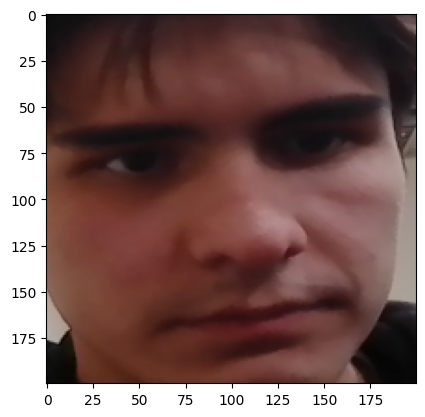

In [18]:
plt.imshow(X_train[1202])

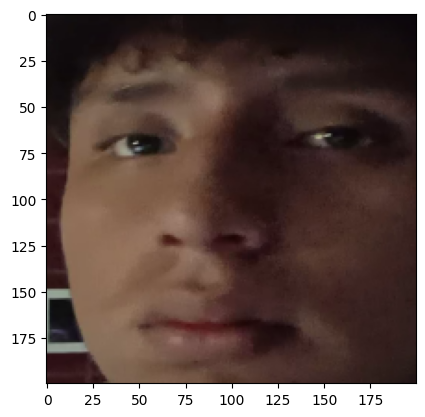

In [19]:
plt.imshow(X_train[500])

In [20]:
labels=[]

In [21]:
labels=['Agus', 'Ale', 'Noni', 'Sebas']

In [22]:
labels

['Agus', 'Ale', 'Noni', 'Sebas']

## Modelo Generico

In [23]:
class ModeloPersonalizado:
    def __init__(self, input_dim, output_dim):
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.modelo = None
        self.historial = None
        self.predicciones = None
        self.matriz_confusion = None

    def construir_modelo(self, configuracion):
        self.modelo = Sequential()
        self.modelo.add(InputLayer(input_shape=self.input_dim))

        # agregamos las capas convolucionales
        for capa in configuracion["capas_convolucionales"]:
            if capa["activation"]=="prelu":
                self.modelo.add(Conv2D(filters=capa["neuronas"], kernel_size=capa["kernel_size"]))
                self.modelo.add(PReLU())
            else:
                self.modelo.add(Conv2D(filters=capa["neuronas"], kernel_size=capa["kernel_size"], activation=capa["activation"]))
            if "max_pooling" in capa:
                self.modelo.add(MaxPooling2D(pool_size=capa["max_pooling"]))
            elif  "avg_pooling" in capa:
                self.modelo.add(AveragePooling2D(pool_size=capa["avg_pooling"]))

        self.modelo.add(Flatten())

        # agregamos capas densas
        for capa in configuracion["capas_ocultas"]:
            if capa["activation"]=="prelu":
                    self.modelo.add(tf.keras.layers.Dense(capa["neuronas"]))
                    self.modelo.add(tf.keras.layers.PReLU())
            else:
                self.modelo.add(Dense(capa["neuronas"], activation=capa["activation"]))
            if "dropout" in capa and capa["dropout"] > 0:
                self.modelo.add(Dropout(capa["dropout"]))

        self.modelo.add(Dense(self.output_dim, activation="softmax"))

    def compilar_modelo(self, learning_rate):
        optimizer = Nadam(learning_rate=learning_rate)
        self.modelo.compile(
            optimizer=optimizer,
            loss="sparse_categorical_crossentropy",
            metrics=["accuracy"]
        )

    def entrenar_modelo(self, X_train, y_train, X_val, y_val, epochs, factor_reduccion, paciencia):
        """
        Un callback en Keras es un conjunto de funciones que puedes usar para personalizar y controlar el proceso de entrenamiento del modelo
        ReduceLROnPlateau es un callback en Keras que se utiliza para reducir la tasa de aprendizaje (learning rate)
        automáticamente si una métrica(val_loss) no mejora después de un número definido de épocas (patience).
        min_lr:El learning rate no se reducirá por debajo de este valor, lo que previene que se acerque a cero.
        lr_scheduler=planificador de la tasa de aprendizaje

        Todo este trabajo se hace poruqe la tasa de aprendizaje se encarga de enontrar el j mas pequeno para los thetas
        si este j o en nuestro caso el val_loss ya no baja mucho o de la nada se subio su valor que posiblemente estemos cerca al mejor
        j o val_loss posible para los tethas y nos conviende dar pasitos mas cortos en la tasa de aprendizaje cuidando de que no sea cero con 
        min_lr
        """
        lr_scheduler = ReduceLROnPlateau(
            monitor="val_loss",
            factor=factor_reduccion,
            patience=paciencia,
            verbose=1,
            min_lr=1e-6
        )

        self.historial = self.modelo.fit(
            X_train, 
            y_train, 
            epochs=epochs, 
            validation_data=(X_val, y_val), 
            callbacks=[lr_scheduler], 
            verbose=1
        )

    def evaluar_modelo(self, X_test, y_test, labels, configuracion):
        probabilidades = self.modelo.predict(X_test)
        self.predicciones = np.argmax(probabilidades, axis=1)

        #El macro average calcula la precisión y el recall de forma independiente para cada clase. Luego toma el promedio aritmético de esas métricas.
        precision = precision_score(y_test, self.predicciones, average="macro")
        recall = recall_score(y_test, self.predicciones, average="macro")

        self.matriz_confusion = confusion_matrix(y_test, self.predicciones)

        resultados = {
            "configuracion": configuracion,
            "precision": precision,
            "recall": recall,
            "historial": self.historial.history,
            "matriz_confusion": self.matriz_confusion
        }

        return resultados

In [24]:
class ModeloPersonalizado:
    def __init__(self, input_dim, output_dim):
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.modelo = None
        self.historial = None
        self.predicciones = None
        self.matriz_confusion = None

    def construir_modelo(self, configuracion):
        self.modelo = Sequential()
        self.modelo.add(InputLayer(input_shape=self.input_dim))

        # agregamos las capas convolucionales
        for capa in configuracion["capas_convolucionales"]:
            if capa["activation"]=="prelu":
                self.modelo.add(Conv2D(filters=capa["neuronas"], kernel_size=capa["kernel_size"]))
                self.modelo.add(PReLU())
            else:
                self.modelo.add(Conv2D(filters=capa["neuronas"], kernel_size=capa["kernel_size"], activation=capa["activation"]))
            if "max_pooling" in capa:
                self.modelo.add(MaxPooling2D(pool_size=capa["max_pooling"]))
            elif  "avg_pooling" in capa:
                self.modelo.add(AveragePooling2D(pool_size=capa["avg_pooling"]))

        self.modelo.add(Flatten())

        # agregamos capas densas
        for capa in configuracion["capas_ocultas"]:
            if capa["activation"]=="prelu":
                    self.modelo.add(tf.keras.layers.Dense(capa["neuronas"]))
                    self.modelo.add(tf.keras.layers.PReLU())
            else:
                self.modelo.add(Dense(capa["neuronas"], activation=capa["activation"]))
            if "dropout" in capa and capa["dropout"] > 0:
                self.modelo.add(Dropout(capa["dropout"]))

        self.modelo.add(Dense(self.output_dim, activation="softmax"))

    def compilar_modelo(self, learning_rate):
        optimizer = Nadam(learning_rate=learning_rate)
        self.modelo.compile(
            optimizer=optimizer,
            loss="sparse_categorical_crossentropy",
            metrics=["accuracy"]
        )

    def entrenar_modelo(self, X_train, y_train, X_val, y_val, epochs, factor_reduccion, paciencia):
        """
        Un callback en Keras es un conjunto de funciones que puedes usar para personalizar y controlar el proceso de entrenamiento del modelo
        ReduceLROnPlateau es un callback en Keras que se utiliza para reducir la tasa de aprendizaje (learning rate)
        automáticamente si una métrica(val_loss) no mejora después de un número definido de épocas (patience).
        min_lr:El learning rate no se reducirá por debajo de este valor, lo que previene que se acerque a cero.
        lr_scheduler=planificador de la tasa de aprendizaje

        Todo este trabajo se hace poruqe la tasa de aprendizaje se encarga de enontrar el j mas pequeno para los thetas
        si este j o en nuestro caso el val_loss ya no baja mucho o de la nada se subio su valor que posiblemente estemos cerca al mejor
        j o val_loss posible para los tethas y nos conviende dar pasitos mas cortos en la tasa de aprendizaje cuidando de que no sea cero con 
        min_lr
        """
        lr_scheduler = ReduceLROnPlateau(
            monitor="val_loss",
            factor=factor_reduccion,
            patience=paciencia,
            verbose=1,
            min_lr=1e-6
        )

        self.historial = self.modelo.fit(
            X_train, 
            y_train, 
            epochs=epochs, 
            validation_data=(X_val, y_val), 
            callbacks=[lr_scheduler], 
            verbose=1
        )

    def evaluar_modelo(self, X_test, y_test, labels, configuracion):
        probabilidades = self.modelo.predict(X_test)
        self.predicciones = np.argmax(probabilidades, axis=1)

        #El macro average calcula la precisión y el recall de forma independiente para cada clase. Luego toma el promedio aritmético de esas métricas.
        precision = precision_score(y_test, self.predicciones, average="macro")
        recall = recall_score(y_test, self.predicciones, average="macro")

        self.matriz_confusion = confusion_matrix(y_test, self.predicciones)

        resultados = {
            "configuracion": configuracion,
            "precision": precision,
            "recall": recall,
            "historial": self.historial.history,
            "matriz_confusion": self.matriz_confusion
        }

        return resultados

## Configramos los modelos

In [25]:
configuraciones=[ 
### LENET 5 - AVG POOLING

    {
       
        "input_dims":  (32,32,1),
        "capas_convolucionales":[
          {"neuronas":6,
           "kernel_size":(5, 5),
           "activation":"tanh",
           "avg_pooling":(2,2)
           },
            {"neuronas":16,
           "kernel_size":(5, 5),
           "activation":"tanh",
           "avg_pooling":(2,2)
           },
            {"neuronas":120,
           "kernel_size":(5, 5),
           "activation":"tanh",
           }
        ],
        "capas_ocultas": [
             {"neuronas": 120, "activation": "tanh"}
            ,{"neuronas": 84, "activation": "tanh"}],
        "learning_rate": 0.001,
        "factor_reduccion": 0.1,
        "output": {"neuronas": 4, "activation": "softmax"}
    },
    # LENET-5 MAX POOLING
     {
       
        "input_dims":  (32,32,1),
        "capas_convolucionales":[
          {"neuronas":6,
           "kernel_size":(5, 5),
           "activation":"tanh",
           "max_pooling":(2,2)
           },
            {"neuronas":16,
           "kernel_size":(5, 5),
           "activation":"tanh",
           "max_pooling":(2,2)
           }
        ],
        "capas_ocultas": [
            {"neuronas": 120, "activation": "tanh"}
            ,{"neuronas": 84, "activation": "tanh"}],
        "learning_rate": 0.001,
        "factor_reduccion": 0.1,
        "output": {"neuronas": 4, "activation": "softmax"}
    },

    ### LENET 5 - AVG POOLING

    {
       
        "input_dims":  (32,32,1),
        "capas_convolucionales":[
          {"neuronas":6,
           "kernel_size":(5, 5),
           "activation":"relu",
           "avg_pooling":(2,2)
           },
            {"neuronas":16,
           "kernel_size":(5, 5),
           "activation":"relu",
           "avg_pooling":(2,2)
           },
            {"neuronas":120,
           "kernel_size":(5, 5),
           "activation":"relu",
           }
        ],
        "capas_ocultas": [
             {"neuronas": 120, "activation": "relu"}
            ,{"neuronas": 84, "activation": "relu"}],
        "learning_rate": 0.001,
        "factor_reduccion": 0.1,
        "output": {"neuronas": 4, "activation": "softmax"}
    },
    # LENET-5 MAX POOLING
     {
       
        "input_dims":  (32,32,1),
        "capas_convolucionales":[
          {"neuronas":6,
           "kernel_size":(5, 5),
           "activation":"relu",
           "max_pooling":(2,2)
           },
            {"neuronas":16,
           "kernel_size":(5, 5),
           "activation":"relu",
           "max_pooling":(2,2)
           }
        ],
        "capas_ocultas": [
            {"neuronas": 120, "activation": "relu"}
            ,{"neuronas": 84, "activation": "relu"}],
        "learning_rate": 0.001,
        "factor_reduccion": 0.1,
        "output": {"neuronas": 4, "activation": "softmax"}
    },
     ### LENET 5 - AVG POOLING

    {
       
        "input_dims":  (32,32,1),
        "capas_convolucionales":[
          {"neuronas":6,
           "kernel_size":(5, 5),
           "activation":"prelu",
           "avg_pooling":(2,2)
           },
            {"neuronas":16,
           "kernel_size":(5, 5),
           "activation":"prelu",
           "avg_pooling":(2,2)
           },
            {"neuronas":120,
           "kernel_size":(5, 5),
           "activation":"prelu",
           }
        ],
        "capas_ocultas": [
             {"neuronas": 120, "activation": "prelu"}
            ,{"neuronas": 84, "activation": "prelu"}],
        "learning_rate": 0.001,
        "factor_reduccion": 0.1,
        "output": {"neuronas": 4, "activation": "softmax"}
    },
    # LENET-5 MAX POOLING
     {
       
        "input_dims":  (32,32,1),
        "capas_convolucionales":[
          {"neuronas":6,
           "kernel_size":(5, 5),
           "activation":"prelu",
           "max_pooling":(2,2)
           },
            {"neuronas":16,
           "kernel_size":(5, 5),
           "activation":"prelu",
           "max_pooling":(2,2)
           }
        ],
        "capas_ocultas": [
            {"neuronas": 120, "activation": "prelu"}
            ,{"neuronas": 84, "activation": "prelu"}],
        "learning_rate": 0.001,
        "factor_reduccion": 0.1,
        "output": {"neuronas": 4, "activation": "softmax"}
    },
#######
### LENET 5 - AVG POOLING

    {
       
        "input_dims":  (32,32,1),
        "capas_convolucionales":[
          {"neuronas":6,
           "kernel_size":(5, 5),
           "activation":"tanh",
           "avg_pooling":(2,2)
           },
            {"neuronas":16,
           "kernel_size":(5, 5),
           "activation":"tanh",
           "avg_pooling":(2,2)
           },
            {"neuronas":120,
           "kernel_size":(5, 5),
           "activation":"tanh",
           }
        ],
        "capas_ocultas": [
             {"neuronas": 120, "activation": "tanh","dropout":0.2}
            ,{"neuronas": 84, "activation": "tanh","dropout":0.2}],
        "learning_rate": 0.001,
        "factor_reduccion": 0.1,
        "output": {"neuronas": 4, "activation": "softmax"}
    },
    # LENET-5 MAX POOLING
     {
       
        "input_dims":  (32,32,1),
        "capas_convolucionales":[
          {"neuronas":6,
           "kernel_size":(5, 5),
           "activation":"tanh",
           "max_pooling":(2,2)
           },
            {"neuronas":16,
           "kernel_size":(5, 5),
           "activation":"tanh",
           "max_pooling":(2,2)
           }
        ],
        "capas_ocultas": [
            {"neuronas": 120, "activation": "tanh","dropout":0.2}
            ,{"neuronas": 84, "activation": "tanh","dropout":0.2}],
        "learning_rate": 0.001,
        "factor_reduccion": 0.1,
        "output": {"neuronas": 4, "activation": "softmax"}
    },

    ### LENET 5 - AVG POOLING

    {
       
        "input_dims":  (32,32,1),
        "capas_convolucionales":[
          {"neuronas":6,
           "kernel_size":(5, 5),
           "activation":"relu",
           "avg_pooling":(2,2)
           },
            {"neuronas":16,
           "kernel_size":(5, 5),
           "activation":"relu",
           "avg_pooling":(2,2)
           },
            {"neuronas":120,
           "kernel_size":(5, 5),
           "activation":"relu",
           }
        ],
        "capas_ocultas": [
             {"neuronas": 120, "activation": "relu","dropout":0.2}
            ,{"neuronas": 84, "activation": "relu","dropout":0.2}],
        "learning_rate": 0.001,
        "factor_reduccion": 0.1,
        "output": {"neuronas": 4, "activation": "softmax"}
    },
    # LENET-5 MAX POOLING
     {
       
        "input_dims":  (32,32,1),
        "capas_convolucionales":[
          {"neuronas":6,
           "kernel_size":(5, 5),
           "activation":"relu",
           "max_pooling":(2,2)
           },
            {"neuronas":16,
           "kernel_size":(5, 5),
           "activation":"relu",
           "max_pooling":(2,2)
           }
        ],
        "capas_ocultas": [
            {"neuronas": 120, "activation": "relu","dropout":0.2}
            ,{"neuronas": 84, "activation": "relu","dropout":0.2}],
        "learning_rate": 0.001,
        "factor_reduccion": 0.1,
        "output": {"neuronas": 4, "activation": "softmax"}
    },
     ### LENET 5 - AVG POOLING

    {
       
        "input_dims":  (32,32,1),
        "capas_convolucionales":[
          {"neuronas":6,
           "kernel_size":(5, 5),
           "activation":"prelu",
           "avg_pooling":(2,2)
           },
            {"neuronas":16,
           "kernel_size":(5, 5),
           "activation":"prelu",
           "avg_pooling":(2,2)
           },
            {"neuronas":120,
           "kernel_size":(5, 5),
           "activation":"prelu",
           }
        ],
        "capas_ocultas": [
             {"neuronas": 120, "activation": "prelu","dropout":0.2}
            ,{"neuronas": 84, "activation": "prelu","dropout":0.2}],
        "learning_rate": 0.001,
        "factor_reduccion": 0.1,
        "output": {"neuronas": 4, "activation": "softmax"}
    },
    # LENET-5 MAX POOLING
     {
       
        "input_dims":  (32,32,1),
        "capas_convolucionales":[
          {"neuronas":6,
           "kernel_size":(5, 5),
           "activation":"prelu",
           "max_pooling":(2,2)
           },
            {"neuronas":16,
           "kernel_size":(5, 5),
           "activation":"prelu",
           "max_pooling":(2,2)
           }
        ],
        "capas_ocultas": [
            {"neuronas": 120, "activation": "prelu","dropout":0.2}
            ,{"neuronas": 84, "activation": "prelu","dropout":0.2}],
        "learning_rate": 0.001,
        "factor_reduccion": 0.1,
        "output": {"neuronas": 4, "activation": "softmax"}
    }





]

In [26]:

resultados_metricas = []

for idx, config in enumerate(configuraciones):
    print(f"Entrenando modelo {idx + 1}/{len(configuraciones)}...")
    input_dims=config["input_dims"]
    X_train_copia=X_train.copy()
    X_test_copia=X_test.copy()
    X_train_copia=redimensionarData(X_train_copia,*input_dims)
    X_test_copia=redimensionarData(X_test_copia,*input_dims)
    X_train_copia=normalizar(X_train_copia)
    X_test_copia=normalizar(X_test_copia)
    print(X_train_copia.shape)
    print(X_test_copia.shape)
    

    modelo = ModeloPersonalizado(input_dim=input_dims, output_dim=4)
    modelo.construir_modelo(config)
    modelo.compilar_modelo(learning_rate=config["learning_rate"])
    modelo.entrenar_modelo(
        X_train=X_train_copia,
        y_train=y_train,
        X_val=X_test_copia,
        y_val=y_test,
        epochs=30,
        factor_reduccion=config["factor_reduccion"],
        paciencia=5,
    )
    
    resultados = modelo.evaluar_modelo(
        X_test=X_test_copia,
        y_test=y_test,
        labels=labels,
        configuracion=config
    )
    resultados_metricas.append(resultados)

    print(f"Modelo {idx + 1} se acabo de entrenar y se guardo")

df_resultados = pd.DataFrame(resultados_metricas)


Entrenando modelo 1/12...
(4800, 32, 32, 1)
(800, 32, 32, 1)


C:\Users\SEBASTIAN\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Epoch 1/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.5842 - loss: 0.9494 - val_accuracy: 0.7038 - val_loss: 3.2015 - learning_rate: 0.0010
Epoch 2/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8306 - loss: 0.4655 - val_accuracy: 0.6938 - val_loss: 3.3394 - learning_rate: 0.0010
Epoch 3/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8371 - loss: 0.4516 - val_accuracy: 0.6975 - val_loss: 3.2808 - learning_rate: 0.0010
Epoch 4/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8392 - loss: 0.4362 - val_accuracy: 0.7125 - val_loss: 3.2481 - learning_rate: 0.0010
Epoch 5/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8533 - loss: 0.3924 - val_accuracy: 0.7063 - val_loss: 3.0154 - learning_rate: 0.0010
Epoch 6/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8652 - loss: 0.3759 - val_accuracy: 0.6963 - val_loss: 3.1958 - learning_rate: 0.0010
Epoch 7/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8701 - loss: 0.3362 - 

C:\Users\SEBASTIAN\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


(4800, 32, 32, 1)
(800, 32, 32, 1)
Epoch 1/30


C:\Users\SEBASTIAN\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


150/150 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.5944 - loss: 0.9396 - val_accuracy: 0.7250 - val_loss: 2.8781 - learning_rate: 0.0010
Epoch 2/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8681 - loss: 0.3505 - val_accuracy: 0.7050 - val_loss: 2.3285 - learning_rate: 0.0010
Epoch 3/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9093 - loss: 0.2430 - val_accuracy: 0.6500 - val_loss: 3.0472 - learning_rate: 0.0010
Epoch 4/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9271 - loss: 0.1952 - val_accuracy: 0.7312 - val_loss: 2.3066 - learning_rate: 0.0010
Epoch 5/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9451 - loss: 0.1528 - val_accuracy: 0.6200 - val_loss: 3.8074 - learning_rate: 0.0010
Epoch 6/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9596 - loss: 0.1215 - val_accuracy: 0.6313 - val_loss: 1.7101 - learning_rate: 0.0010
Epoch 7/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9724 - loss: 0.0851 - val_accurac

C:\Users\SEBASTIAN\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


(4800, 32, 32, 1)
(800, 32, 32, 1)
Epoch 1/30


C:\Users\SEBASTIAN\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


150/150 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.5156 - loss: 1.0284 - val_accuracy: 0.7038 - val_loss: 2.6018 - learning_rate: 0.0010
Epoch 2/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8606 - loss: 0.3966 - val_accuracy: 0.7175 - val_loss: 2.8637 - learning_rate: 0.0010
Epoch 3/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9146 - loss: 0.2406 - val_accuracy: 0.7437 - val_loss: 2.5422 - learning_rate: 0.0010
Epoch 4/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9390 - loss: 0.1702 - val_accuracy: 0.6900 - val_loss: 3.1816 - learning_rate: 0.0010
Epoch 5/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9513 - loss: 0.1428 - val_accuracy: 0.6112 - val_loss: 3.1452 - learning_rate: 0.0010
Epoch 6/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9552 - loss: 0.1277 - val_accuracy: 0.7487 - val_loss: 2.7913 - learning_rate: 0.0010
Epoch 7/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9693 - loss: 0.0911 - val_accurac

C:\Users\SEBASTIAN\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


(4800, 32, 32, 1)
(800, 32, 32, 1)
Epoch 1/30


C:\Users\SEBASTIAN\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


150/150 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.5128 - loss: 1.0245 - val_accuracy: 0.5612 - val_loss: 2.5096 - learning_rate: 0.0010
Epoch 2/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8774 - loss: 0.3450 - val_accuracy: 0.5312 - val_loss: 2.9473 - learning_rate: 0.0010
Epoch 3/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9195 - loss: 0.2317 - val_accuracy: 0.6438 - val_loss: 2.5371 - learning_rate: 0.0010
Epoch 4/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9412 - loss: 0.1687 - val_accuracy: 0.4863 - val_loss: 3.3544 - learning_rate: 0.0010
Epoch 5/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9561 - loss: 0.1270 - val_accuracy: 0.5713 - val_loss: 3.0875 - learning_rate: 0.0010
Epoch 6/30
144/150 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9720 - loss: 0.0835
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9720 - loss: 0.0836 - val_accurac

C:\Users\SEBASTIAN\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


(4800, 32, 32, 1)
(800, 32, 32, 1)


C:\Users\SEBASTIAN\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Epoch 1/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.4807 - loss: 1.0629 - val_accuracy: 0.6662 - val_loss: 3.3197 - learning_rate: 0.0010
Epoch 2/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8601 - loss: 0.4046 - val_accuracy: 0.6913 - val_loss: 2.7675 - learning_rate: 0.0010
Epoch 3/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9181 - loss: 0.2203 - val_accuracy: 0.7375 - val_loss: 2.4499 - learning_rate: 0.0010
Epoch 4/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9431 - loss: 0.1531 - val_accuracy: 0.7487 - val_loss: 2.4074 - learning_rate: 0.0010
Epoch 5/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9613 - loss: 0.1083 - val_accuracy: 0.7212 - val_loss: 2.2665 - learning_rate: 0.0010
Epoch 6/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9724 - loss: 0.0746 - val_accuracy: 0.6850 - val_loss: 1.8875 - learning_rate: 0.0010
Epoch 7/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9752 - loss: 0.0692 - 

C:\Users\SEBASTIAN\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


(4800, 32, 32, 1)
(800, 32, 32, 1)


C:\Users\SEBASTIAN\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Epoch 1/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.5156 - loss: 1.0157 - val_accuracy: 0.6963 - val_loss: 2.9217 - learning_rate: 0.0010
Epoch 2/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8940 - loss: 0.3059 - val_accuracy: 0.7075 - val_loss: 2.7251 - learning_rate: 0.0010
Epoch 3/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9331 - loss: 0.1937 - val_accuracy: 0.7275 - val_loss: 3.0721 - learning_rate: 0.0010
Epoch 4/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9512 - loss: 0.1395 - val_accuracy: 0.7325 - val_loss: 2.5611 - learning_rate: 0.0010
Epoch 5/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9675 - loss: 0.0967 - val_accuracy: 0.7362 - val_loss: 2.4252 - learning_rate: 0.0010
Epoch 6/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9730 - loss: 0.0734 - val_accuracy: 0.6775 - val_loss: 2.6960 - learning_rate: 0.0010
Epoch 7/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9824 - loss: 0.0563 - 

C:\Users\SEBASTIAN\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


(4800, 32, 32, 1)
(800, 32, 32, 1)


C:\Users\SEBASTIAN\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Epoch 1/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.5475 - loss: 0.9926 - val_accuracy: 0.6900 - val_loss: 2.9248 - learning_rate: 0.0010
Epoch 2/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8206 - loss: 0.4794 - val_accuracy: 0.7188 - val_loss: 2.8916 - learning_rate: 0.0010
Epoch 3/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8414 - loss: 0.4400 - val_accuracy: 0.7150 - val_loss: 3.1077 - learning_rate: 0.0010
Epoch 4/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8403 - loss: 0.4353 - val_accuracy: 0.7175 - val_loss: 3.2279 - learning_rate: 0.0010
Epoch 5/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8575 - loss: 0.4032 - val_accuracy: 0.7138 - val_loss: 2.6963 - learning_rate: 0.0010
Epoch 6/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8572 - loss: 0.3904 - val_accuracy: 0.7113 - val_loss: 2.9997 - learning_rate: 0.0010
Epoch 7/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8708 - loss: 0.3448 - 

C:\Users\SEBASTIAN\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


(4800, 32, 32, 1)
(800, 32, 32, 1)


C:\Users\SEBASTIAN\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Epoch 1/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.5865 - loss: 0.9462 - val_accuracy: 0.7212 - val_loss: 2.7560 - learning_rate: 0.0010
Epoch 2/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8618 - loss: 0.3630 - val_accuracy: 0.6550 - val_loss: 2.5713 - learning_rate: 0.0010
Epoch 3/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9087 - loss: 0.2505 - val_accuracy: 0.6575 - val_loss: 2.4586 - learning_rate: 0.0010
Epoch 4/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9377 - loss: 0.1776 - val_accuracy: 0.6612 - val_loss: 2.8364 - learning_rate: 0.0010
Epoch 5/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9569 - loss: 0.1294 - val_accuracy: 0.6625 - val_loss: 2.8327 - learning_rate: 0.0010
Epoch 6/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9578 - loss: 0.1247 - val_accuracy: 0.7063 - val_loss: 2.9485 - learning_rate: 0.0010
Epoch 7/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9665 - loss: 0.0984 - 

C:\Users\SEBASTIAN\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


(4800, 32, 32, 1)
(800, 32, 32, 1)


C:\Users\SEBASTIAN\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Epoch 1/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.4501 - loss: 1.1248 - val_accuracy: 0.4875 - val_loss: 2.6887 - learning_rate: 0.0010
Epoch 2/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8151 - loss: 0.4842 - val_accuracy: 0.6087 - val_loss: 2.1010 - learning_rate: 0.0010
Epoch 3/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8830 - loss: 0.3086 - val_accuracy: 0.7075 - val_loss: 1.5818 - learning_rate: 0.0010
Epoch 4/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9213 - loss: 0.2126 - val_accuracy: 0.7262 - val_loss: 1.3447 - learning_rate: 0.0010
Epoch 5/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9468 - loss: 0.1410 - val_accuracy: 0.7212 - val_loss: 1.5464 - learning_rate: 0.0010
Epoch 6/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9522 - loss: 0.1190 - val_accuracy: 0.7487 - val_loss: 1.3902 - learning_rate: 0.0010
Epoch 7/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9643 - loss: 0.0946 - 

C:\Users\SEBASTIAN\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


(4800, 32, 32, 1)
(800, 32, 32, 1)
Epoch 1/30


C:\Users\SEBASTIAN\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


150/150 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.4979 - loss: 1.0695 - val_accuracy: 0.6800 - val_loss: 2.5622 - learning_rate: 0.0010
Epoch 2/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8670 - loss: 0.3952 - val_accuracy: 0.6837 - val_loss: 2.2039 - learning_rate: 0.0010
Epoch 3/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9201 - loss: 0.2350 - val_accuracy: 0.6725 - val_loss: 1.5212 - learning_rate: 0.0010
Epoch 4/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9356 - loss: 0.1752 - val_accuracy: 0.6662 - val_loss: 1.6480 - learning_rate: 0.0010
Epoch 5/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9652 - loss: 0.1084 - val_accuracy: 0.7025 - val_loss: 1.6578 - learning_rate: 0.0010
Epoch 6/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9710 - loss: 0.0919 - val_accuracy: 0.6963 - val_loss: 1.3321 - learning_rate: 0.0010
Epoch 7/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9794 - loss: 0.0653 - val_accurac

C:\Users\SEBASTIAN\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


(4800, 32, 32, 1)
(800, 32, 32, 1)


C:\Users\SEBASTIAN\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Epoch 1/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.4675 - loss: 1.0718 - val_accuracy: 0.7013 - val_loss: 1.9516 - learning_rate: 0.0010
Epoch 2/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8574 - loss: 0.3874 - val_accuracy: 0.6850 - val_loss: 1.4059 - learning_rate: 0.0010
Epoch 3/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9018 - loss: 0.2570 - val_accuracy: 0.5213 - val_loss: 1.6769 - learning_rate: 0.0010
Epoch 4/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9368 - loss: 0.1605 - val_accuracy: 0.7225 - val_loss: 1.2150 - learning_rate: 0.0010
Epoch 5/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9589 - loss: 0.1192 - val_accuracy: 0.6150 - val_loss: 1.7724 - learning_rate: 0.0010
Epoch 6/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9694 - loss: 0.0883 - val_accuracy: 0.6775 - val_loss: 1.4592 - learning_rate: 0.0010
Epoch 7/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9769 - loss: 0.0752 -

C:\Users\SEBASTIAN\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


(4800, 32, 32, 1)
(800, 32, 32, 1)


C:\Users\SEBASTIAN\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Epoch 1/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.4830 - loss: 1.0513 - val_accuracy: 0.7063 - val_loss: 2.1927 - learning_rate: 0.0010
Epoch 2/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8548 - loss: 0.3888 - val_accuracy: 0.7063 - val_loss: 1.6859 - learning_rate: 0.0010
Epoch 3/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9256 - loss: 0.1932 - val_accuracy: 0.7050 - val_loss: 1.3878 - learning_rate: 0.0010
Epoch 4/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9559 - loss: 0.1285 - val_accuracy: 0.7125 - val_loss: 1.4370 - learning_rate: 0.0010
Epoch 5/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9680 - loss: 0.0938 - val_accuracy: 0.7175 - val_loss: 1.3615 - learning_rate: 0.0010
Epoch 6/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9721 - loss: 0.0769 - val_accuracy: 0.6862 - val_loss: 1.2623 - learning_rate: 0.0010
Epoch 7/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9792 - loss: 0.0600 - 

C:\Users\SEBASTIAN\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Modelo 1:
----------------------------------------
Configuración del modelo:
Capas Ocultas:
  Capa 1: 120 neuronas, activación='tanh', dropout=0
  Capa 2: 84 neuronas, activación='tanh', dropout=0
Learning Rate: 0.001
Factor de Reducción: 0.1
Salida: 4 neuronas, activación='softmax'

Métricas del modelo:
Precisión: 0.5847
Recall: 0.5725

Graficando historial de entrenamiento...


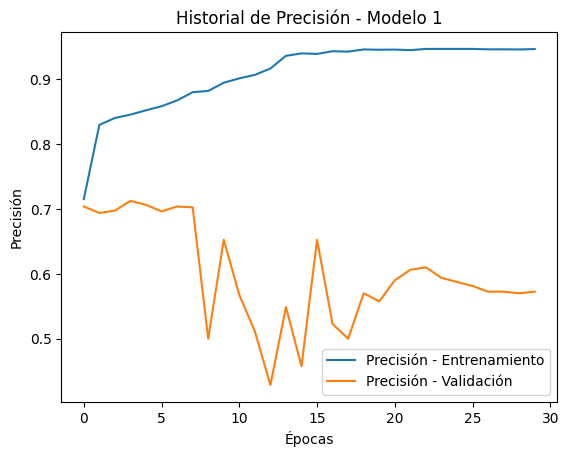

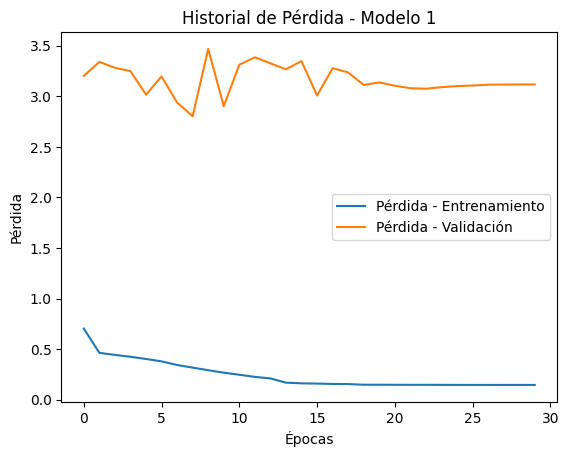


Matriz de Confusión:


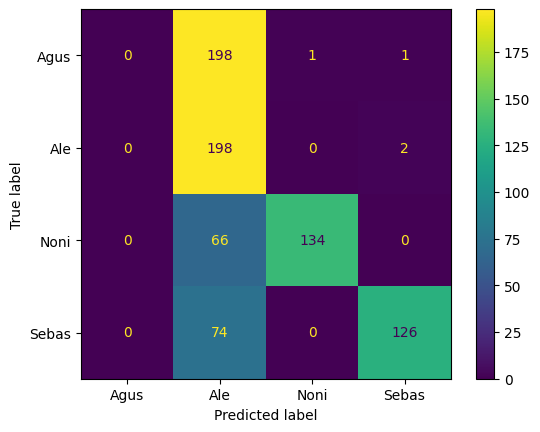



Modelo 2:
----------------------------------------
Configuración del modelo:
Capas Ocultas:
  Capa 1: 120 neuronas, activación='tanh', dropout=0
  Capa 2: 84 neuronas, activación='tanh', dropout=0
Learning Rate: 0.001
Factor de Reducción: 0.1
Salida: 4 neuronas, activación='softmax'

Métricas del modelo:
Precisión: 0.4291
Recall: 0.5388

Graficando historial de entrenamiento...


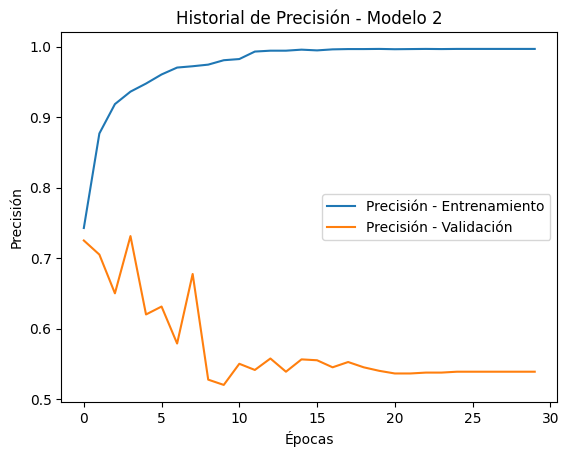

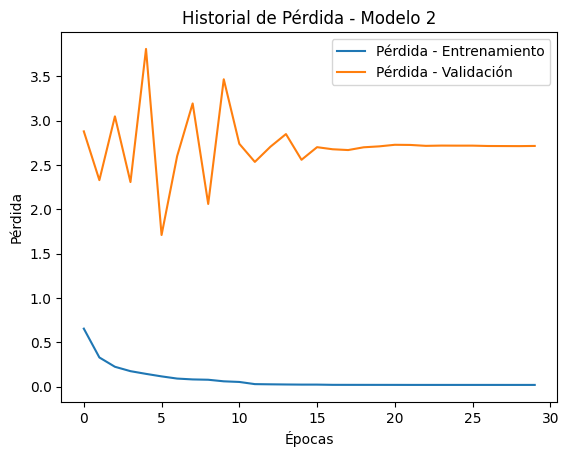


Matriz de Confusión:


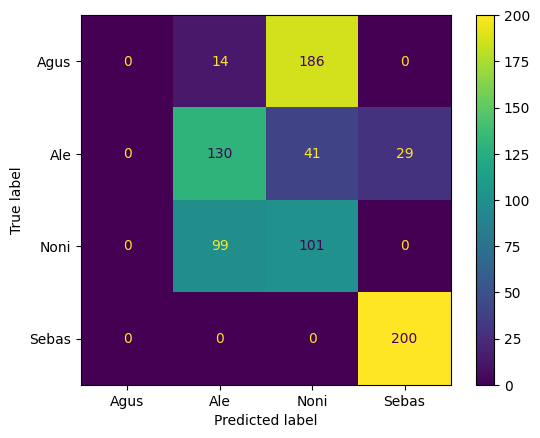



Modelo 3:
----------------------------------------
Configuración del modelo:
Capas Ocultas:
  Capa 1: 120 neuronas, activación='relu', dropout=0
  Capa 2: 84 neuronas, activación='relu', dropout=0
Learning Rate: 0.001
Factor de Reducción: 0.1
Salida: 4 neuronas, activación='softmax'

Métricas del modelo:
Precisión: 0.5425
Recall: 0.7000

Graficando historial de entrenamiento...


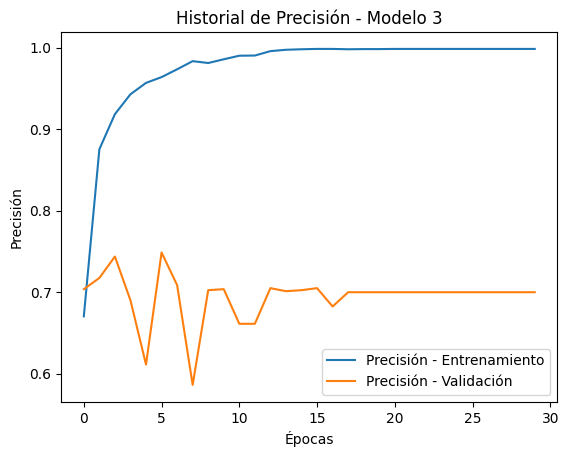

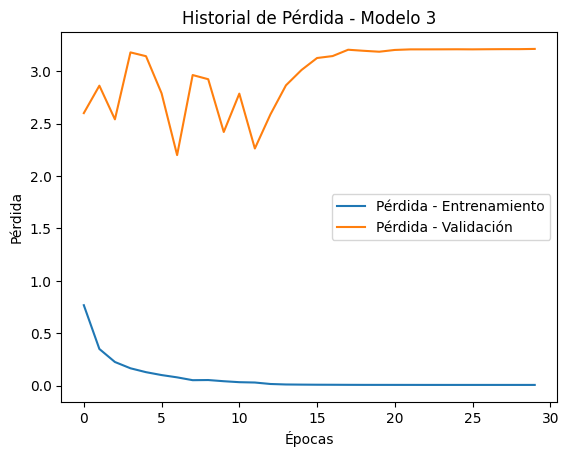


Matriz de Confusión:


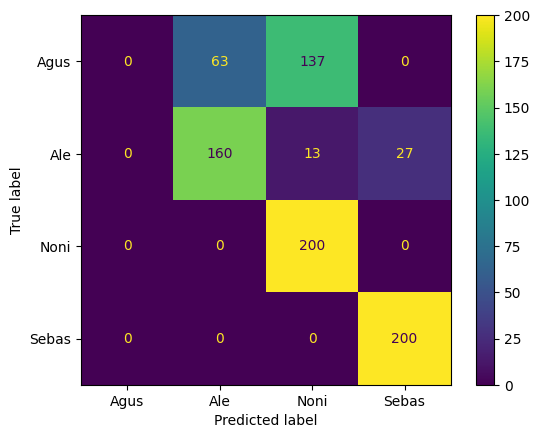



Modelo 4:
----------------------------------------
Configuración del modelo:
Capas Ocultas:
  Capa 1: 120 neuronas, activación='relu', dropout=0
  Capa 2: 84 neuronas, activación='relu', dropout=0
Learning Rate: 0.001
Factor de Reducción: 0.1
Salida: 4 neuronas, activación='softmax'

Métricas del modelo:
Precisión: 0.3368
Recall: 0.4837

Graficando historial de entrenamiento...


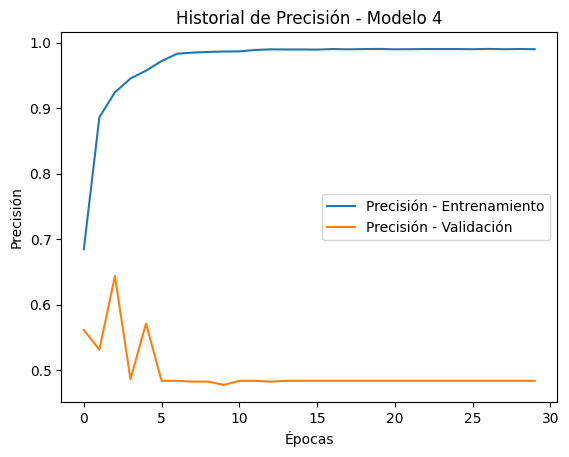

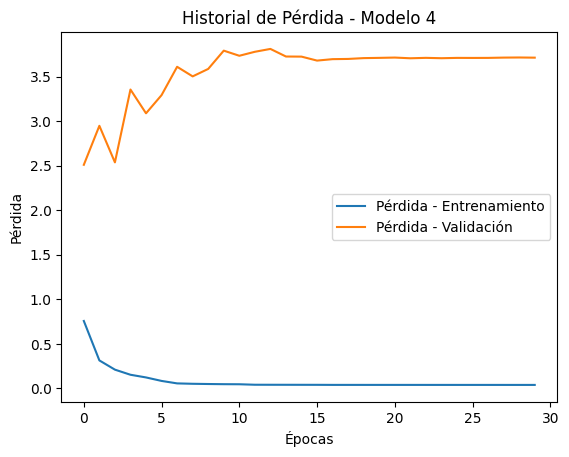


Matriz de Confusión:


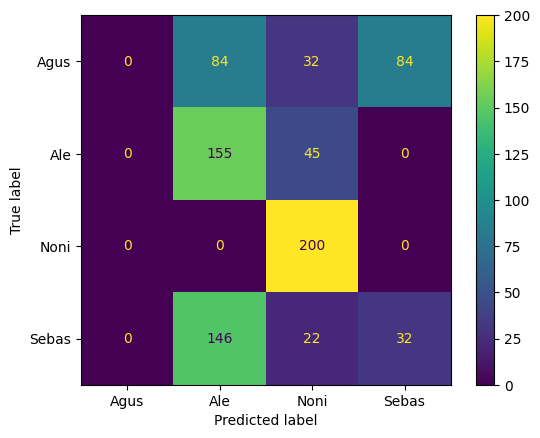



Modelo 5:
----------------------------------------
Configuración del modelo:
Capas Ocultas:
  Capa 1: 120 neuronas, activación='prelu', dropout=0
  Capa 2: 84 neuronas, activación='prelu', dropout=0
Learning Rate: 0.001
Factor de Reducción: 0.1
Salida: 4 neuronas, activación='softmax'

Métricas del modelo:
Precisión: 0.5859
Recall: 0.7025

Graficando historial de entrenamiento...


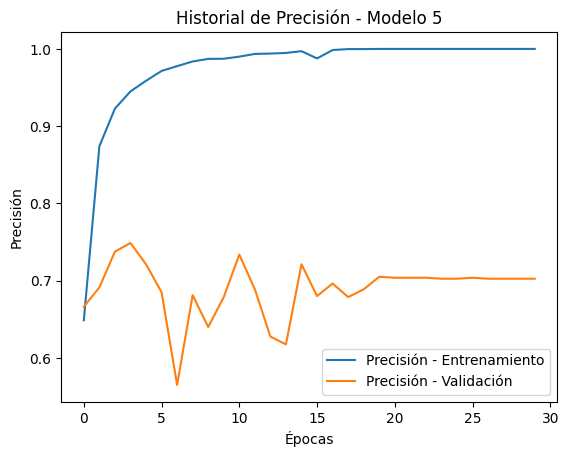

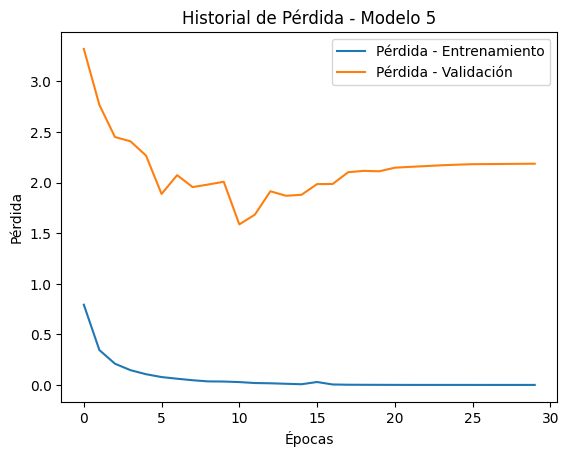


Matriz de Confusión:


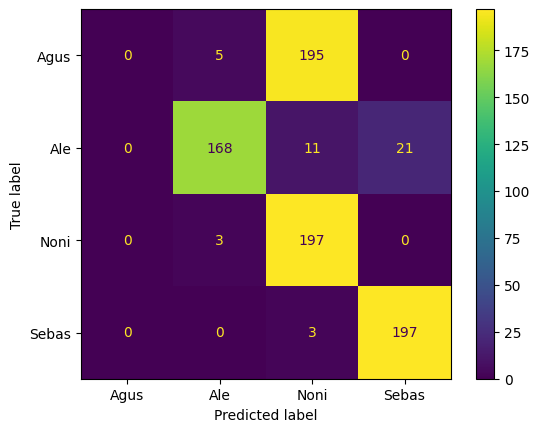



Modelo 6:
----------------------------------------
Configuración del modelo:
Capas Ocultas:
  Capa 1: 120 neuronas, activación='prelu', dropout=0
  Capa 2: 84 neuronas, activación='prelu', dropout=0
Learning Rate: 0.001
Factor de Reducción: 0.1
Salida: 4 neuronas, activación='softmax'

Métricas del modelo:
Precisión: 0.5636
Recall: 0.7212

Graficando historial de entrenamiento...


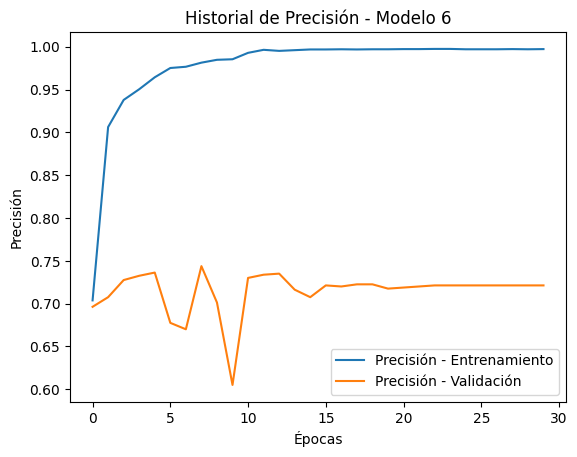

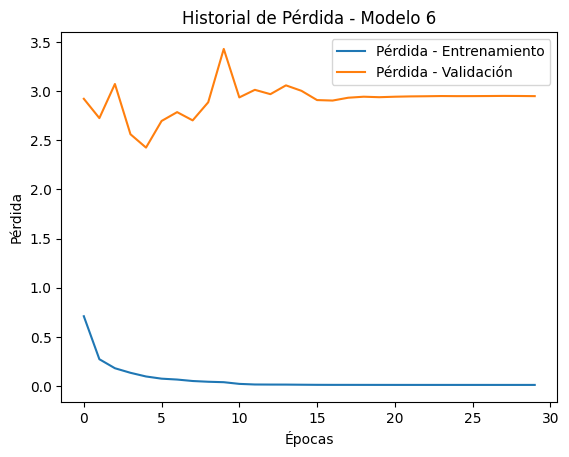


Matriz de Confusión:


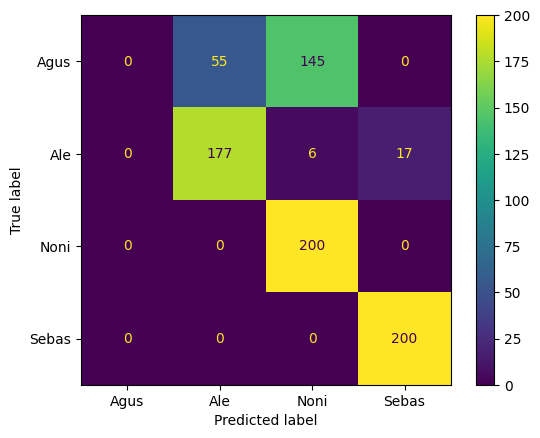



Modelo 7:
----------------------------------------
Configuración del modelo:
Capas Ocultas:
  Capa 1: 120 neuronas, activación='tanh', dropout=0.2
  Capa 2: 84 neuronas, activación='tanh', dropout=0.2
Learning Rate: 0.001
Factor de Reducción: 0.1
Salida: 4 neuronas, activación='softmax'

Métricas del modelo:
Precisión: 0.6111
Recall: 0.7388

Graficando historial de entrenamiento...


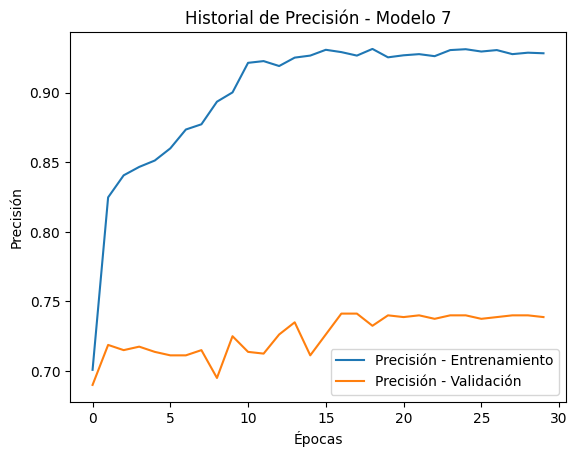

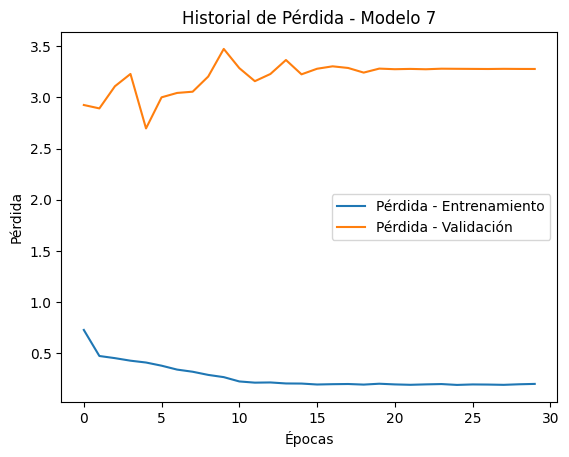


Matriz de Confusión:


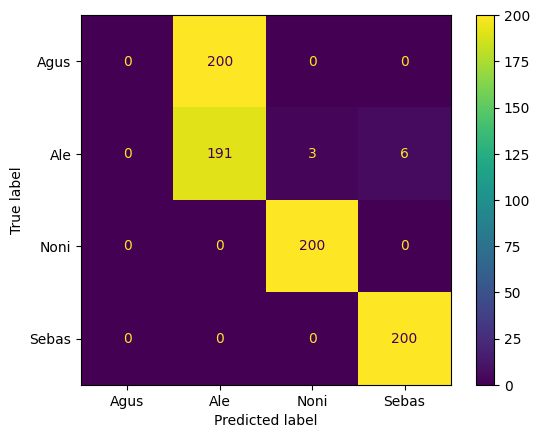



Modelo 8:
----------------------------------------
Configuración del modelo:
Capas Ocultas:
  Capa 1: 120 neuronas, activación='tanh', dropout=0.2
  Capa 2: 84 neuronas, activación='tanh', dropout=0.2
Learning Rate: 0.001
Factor de Reducción: 0.1
Salida: 4 neuronas, activación='softmax'

Métricas del modelo:
Precisión: 0.4966
Recall: 0.6475

Graficando historial de entrenamiento...


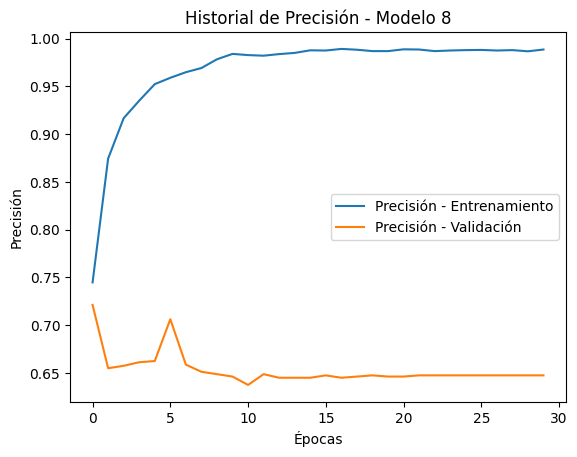

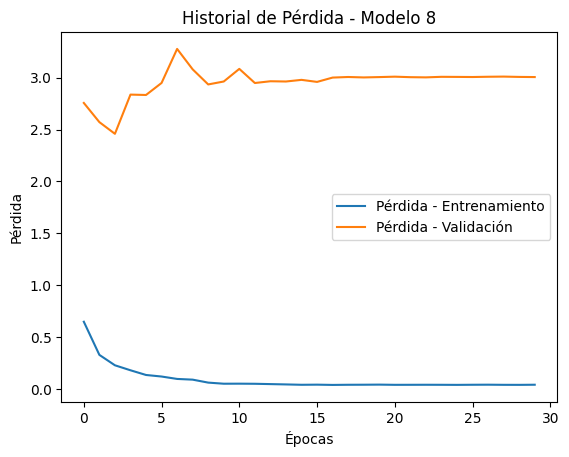


Matriz de Confusión:


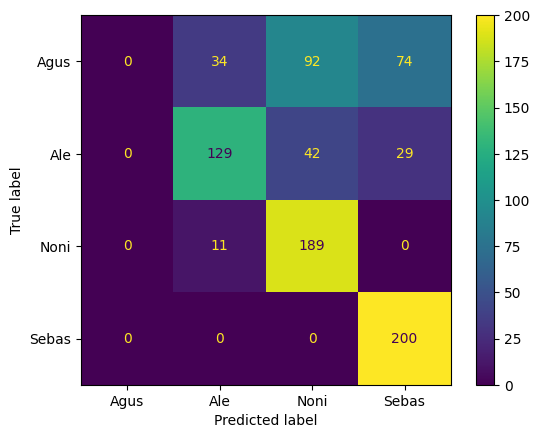



Modelo 9:
----------------------------------------
Configuración del modelo:
Capas Ocultas:
  Capa 1: 120 neuronas, activación='relu', dropout=0.2
  Capa 2: 84 neuronas, activación='relu', dropout=0.2
Learning Rate: 0.001
Factor de Reducción: 0.1
Salida: 4 neuronas, activación='softmax'

Métricas del modelo:
Precisión: 0.6092
Recall: 0.7388

Graficando historial de entrenamiento...


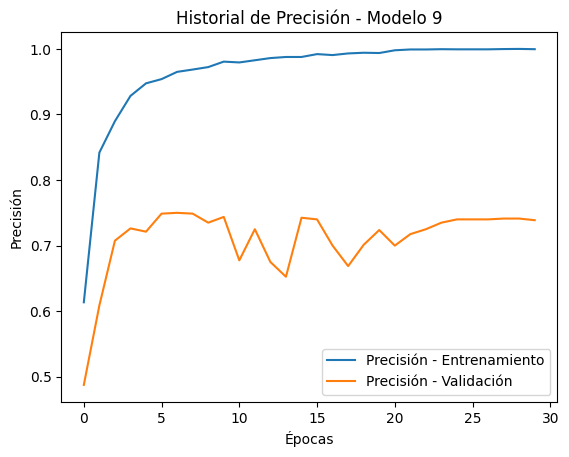

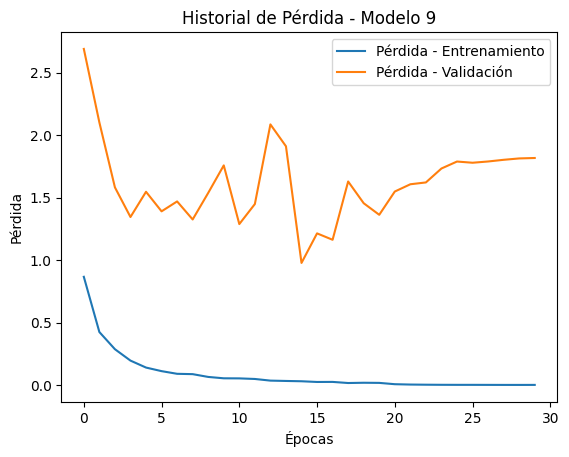


Matriz de Confusión:


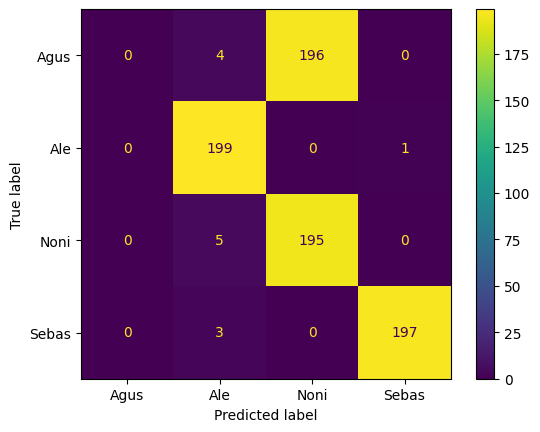



Modelo 10:
----------------------------------------
Configuración del modelo:
Capas Ocultas:
  Capa 1: 120 neuronas, activación='relu', dropout=0.2
  Capa 2: 84 neuronas, activación='relu', dropout=0.2
Learning Rate: 0.001
Factor de Reducción: 0.1
Salida: 4 neuronas, activación='softmax'

Métricas del modelo:
Precisión: 0.5855
Recall: 0.7125

Graficando historial de entrenamiento...


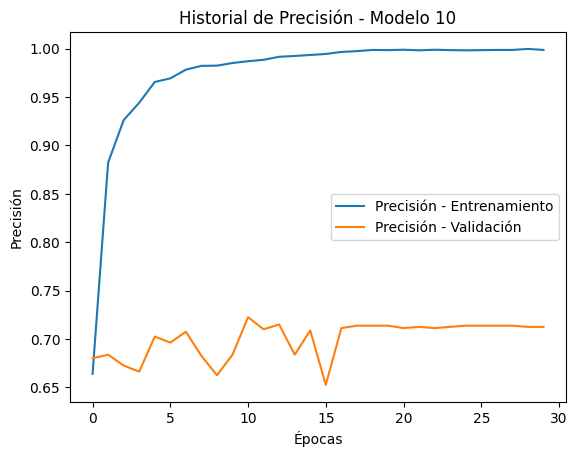

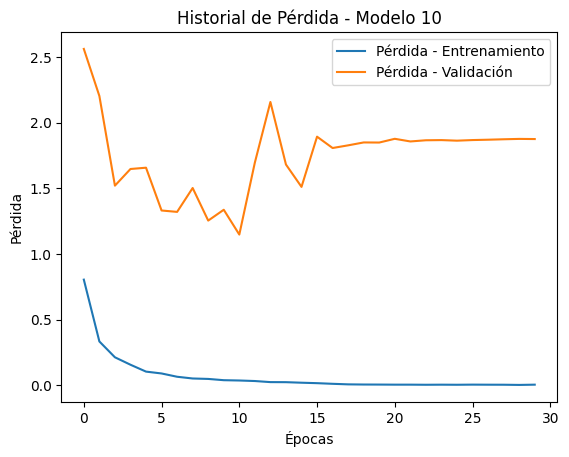


Matriz de Confusión:


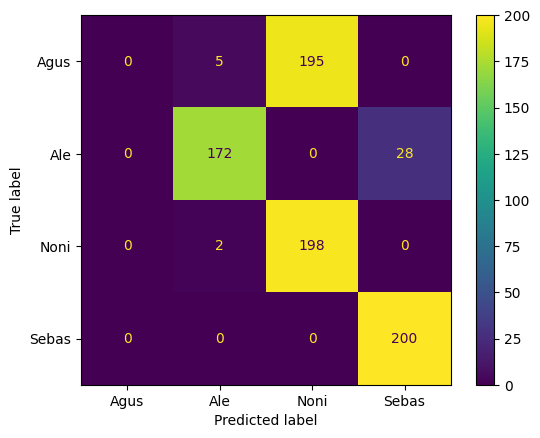



Modelo 11:
----------------------------------------
Configuración del modelo:
Capas Ocultas:
  Capa 1: 120 neuronas, activación='prelu', dropout=0.2
  Capa 2: 84 neuronas, activación='prelu', dropout=0.2
Learning Rate: 0.001
Factor de Reducción: 0.1
Salida: 4 neuronas, activación='softmax'

Métricas del modelo:
Precisión: 0.5756
Recall: 0.7325

Graficando historial de entrenamiento...


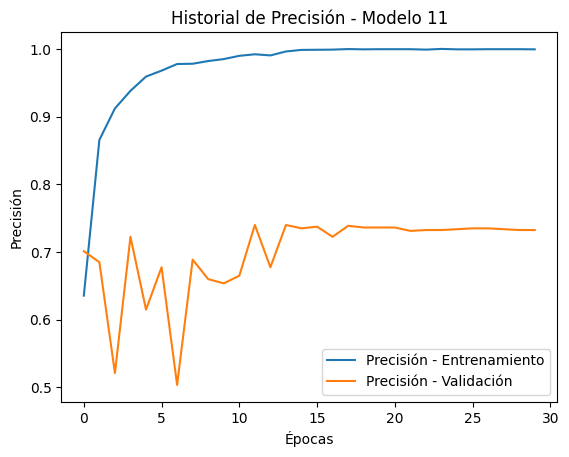

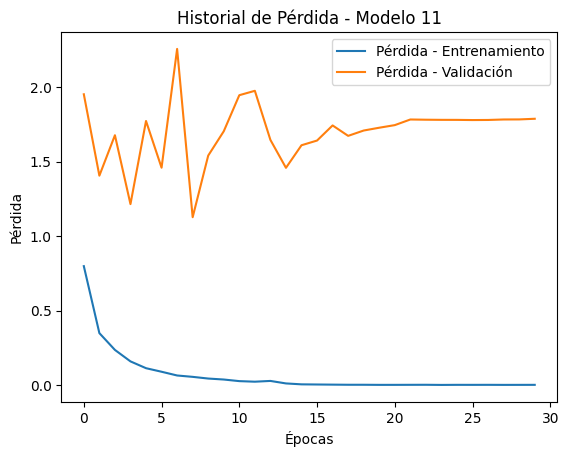


Matriz de Confusión:


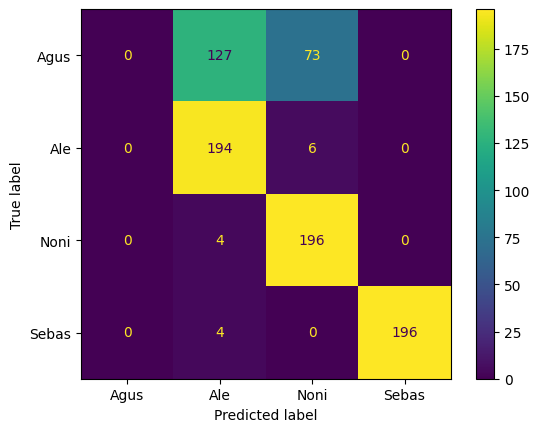



Modelo 12:
----------------------------------------
Configuración del modelo:
Capas Ocultas:
  Capa 1: 120 neuronas, activación='prelu', dropout=0.2
  Capa 2: 84 neuronas, activación='prelu', dropout=0.2
Learning Rate: 0.001
Factor de Reducción: 0.1
Salida: 4 neuronas, activación='softmax'

Métricas del modelo:
Precisión: 0.5640
Recall: 0.6600

Graficando historial de entrenamiento...


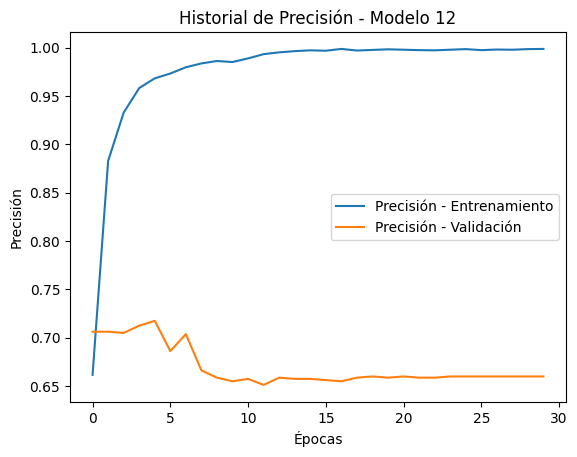

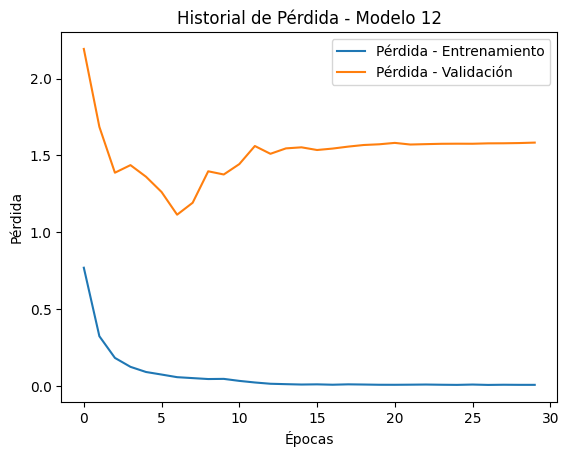


Matriz de Confusión:


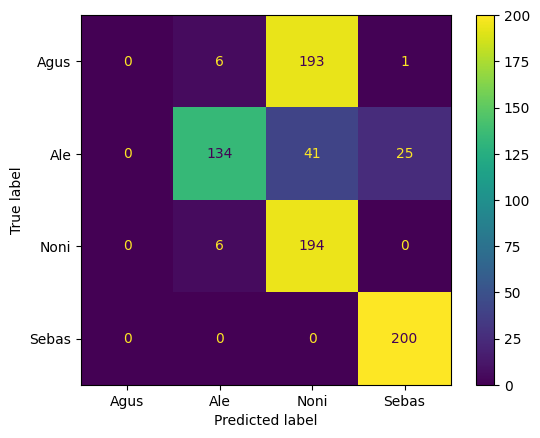

In [27]:
def mostrar_configuracion(configuracion):
    salida = []
    salida.append("Capas Ocultas:")
    for i, capa in enumerate(configuracion["capas_ocultas"]):
        salida.append(f"  Capa {i + 1}: {capa['neuronas']} neuronas, activación='{capa['activation']}', dropout={capa.get('dropout', 0)}")
    salida.append(f"Learning Rate: {configuracion['learning_rate']}")
    salida.append(f"Factor de Reducción: {configuracion['factor_reduccion']}")
    salida.append(f"Salida: {configuracion['output']['neuronas']} neuronas, activación='{configuracion['output']['activation']}'")
    return "\n".join(salida)

def mostrar_todo_dataframe(df, labels):
    for index, fila in df.iterrows():
        print(f"Modelo {index + 1}:")
        print("-" * 40)
        
        print("Configuración del modelo:")
        print(mostrar_configuracion(fila["configuracion"]))
        
        print("\nMétricas del modelo:")
        print(f"Precisión: {fila['precision']:.4f}")
        print(f"Recall: {fila['recall']:.4f}")
        
        historial = fila["historial"]
        print("\nGraficando historial de entrenamiento...")
        plt.plot(historial["accuracy"], label="Precisión - Entrenamiento")
        plt.plot(historial["val_accuracy"], label="Precisión - Validación")
        plt.title(f"Historial de Precisión - Modelo {index + 1}")
        plt.xlabel("Épocas")
        plt.ylabel("Precisión")
        plt.legend()
        plt.show()

        plt.plot(historial["loss"], label="Pérdida - Entrenamiento")
        plt.plot(historial["val_loss"], label="Pérdida - Validación")
        plt.title(f"Historial de Pérdida - Modelo {index + 1}")
        plt.xlabel("Épocas")
        plt.ylabel("Pérdida")
        plt.legend()
        plt.show()

        print("\nMatriz de Confusión:")
        cm_display = ConfusionMatrixDisplay(fila["matriz_confusion"], display_labels=labels)
        cm_display.plot()
        plt.show()

        print("\n" + "=" * 50 + "\n")

mostrar_todo_dataframe(df_resultados, labels=labels)
